In [1]:
data_partition = {
        "gwilliams2023": {
            "testing_subjects": [19, 20, 21],
            "testing_tasks": [0],
        }
        # "schoffelen2022": {
        #     "testing_subjects": [],
        #     "testing_tasks": [8, 9],
        # },
}

In [2]:
# from utils.compression import compress_directories, decompress_directories

# for base_path, batch_type in data_partition.items():
#     decompress_directories(
#         source_path=f'downloaded_data/{base_path}',
#         destination_path=f'data/{destination_path}',
#         checksum_file_name="checksums.txt",
#         delete_compressed_files=True,
#         num_workers=None
#     )

In [3]:
from config import SimpleConvConfig
from models.simpleconv import SimpleConv
import torch

model_config = SimpleConvConfig(
    # Str to list of possible conditions
    conditions={'subject': []},
    # Channels
    in_channels=208,
    out_channels=128,
    hidden_dim=512,
    dropout=0.2,
    # Sensor layout settings
    layout_dim=2,
    layout_proj=False,
    layout_scaling="minmax",
    # Merger with spatial attn
    merger=True,
    merger_emb_type='fourier',
    merger_emb_dim=512,
    merger_channels=256,
    merger_dropout=0.2,
    merger_conditional=None,
    # Inital
    initial_linear=256,
    initial_depth=1,
    # Conditional layers
    conditional_layers=True,
    conditional_layers_dim='hidden_dim',  # input or hidden_dim
    # Conv layer overall structure
    depth=6,
    kernel_size=3,
    growth=1.0,
    dilation_growth=2,
    dilation_period=5,
    glu=1,
    conv_dropout=0.2,
    dropout_input=0.2,
    batch_norm=True,
    # Quantizer
    quantizer=False,
    num_codebooks=0,
    codebook_size=0,
    quantizer_commitment=0,
    quantizer_temp_init=0,
    quantizer_temp_min=0,
    quantizer_temp_decay=0,
    # Transformers Encoders
    transformer_input='continuous',
    transformer_encoder_emb='groupconv',
    transformer_encoder_layers=2,
    transformer_encoder_heads=8,
    # Transformer Decoders
    transformer_decoder_emb=None,
    transformer_decoder_layers=0,
    transformer_decoder_heads=0,
    transformer_decoder_dim=0,
)

In [4]:
from train.training_session_v0 import TrainingSessionV0
from config import TrainingConfigV0
import multiprocessing

config = TrainingConfigV0(
    brain_encoder_config=model_config,
    data_partition=data_partition,
    # Pre-processing parameters
    # Brain
    new_freq=100,
    frequency_bands={'all': (0.4, 80)},
    max_random_shift=0.2,
    window_size= 4,
    window_stride=1,
    brain_clipping=20,
    baseline_window=0.5,
    notch_filter=True,
    scaling='both',
    # Hyperparameters
    learning_rate = 5e-4,
    weight_decay = 1e-4,
    epochs = 50,
    batch_size = 256,
    use_clip_loss = True,
    use_mse_loss = True,
    alpha = 0.9,
    random_test_size = 10,
    seed = 42,
)

session = TrainingSessionV0(
    config=config,
    studies={"gwilliams2023": 'audio'},
    data_path='data',
    save_path='saves/Dec16_baseline',
    clear_cache=False,
)

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

Conditional layer subject initialized with 28 conditions
TransformerEncoder initialized with 2 layers, 512 d_model, 8 nhead
	Embedding: groupconv, params: 6307328
SimpleConv initialized with 25001856 parameters, cond: ['subject']
Merger True, merger channels 256
ConvBlocks: 6, hidden_dim: 512, params 14170112


In [5]:
# try:
#     session.train(
#         device='cuda',
#         buffer_size=30,
#         num_workers=multiprocessing.cpu_count() - 2,
#         max_cache_size=200,
#         current_epoch=0,
#     )
# except KeyboardInterrupt as e:
#     print('Exited')

In [6]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

# device='cuda'

# session = load_training_session(
#     save_path='saves/Dec16_baseline/epoch_8',
#     studies={"gwilliams2023": 'audio'},
#     data_path='data',
# )

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

dataloader.start_fetching(
    recordings=[
        session.recordings[0]
    ]
)
batch = dataloader.get_recording()
brain, audio, recording = batch.brain_segments['all'], batch.audio_segments, batch.recording

# conditions = {
#     "study": f'{recording.study_name}',
#     "subject": f'{recording.study_name}_{recording.subject_id}',
# }
# session.model.to(device)

# with torch.no_grad():
#     pred, _ = session.model(
#         x=brain, 
#         recording=recording, 
#         conditions=conditions , 
#         train=False
#     )
    
dataloader.stop()

2024-12-18 11:26:49,926	INFO worker.py:1821 -- Started a local Ray instance.


(AudioBatchFetcher pid=2916) start_indices seconds difference top 10: tensor([0.9900, 0.9900, 0.9900, 0.9900, 0.9800, 0.9800, 0.9700, 0.9700, 0.9700,
(AudioBatchFetcher pid=2916)         0.9500])
(AudioBatchFetcher pid=2916) mean: 0.4907664358615875, std: 0.2799198031425476


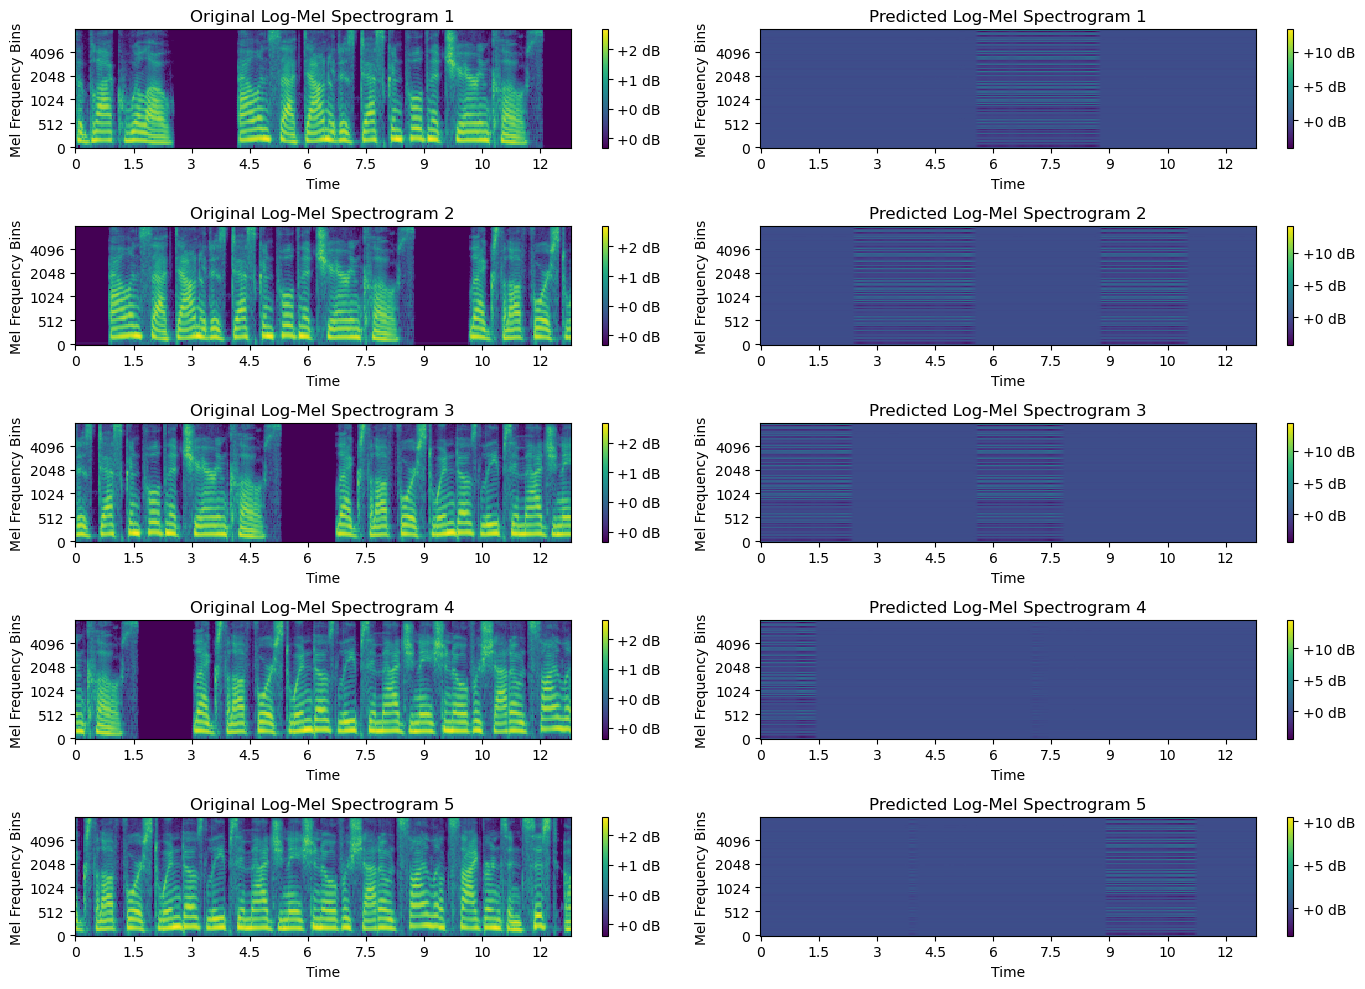

In [8]:
from utils.plot import mel_spectrogram

mel_spectrogram(
    x=audio[:5].to('cpu'),
    max_plots=5,
    x_pred=pred{:5}.to('cpu'),
)